<h1 style="background:#0554f2; border:0; border-radius: 8px; color:#f5f6f7"><center>Tabular Playground Series - Sep 2022</center></h1>

The competing Kaggle merchandise stores we saw in [January's Tabular Playground](https://www.kaggle.com/c/tabular-playground-series-jan-2022) are at it again. The task for this month's competitions is a bit more complicated. Not only are there six countries and four books to forecast, but you're being asked to forecast sales during the tumultuous year 2021.

---

**Goal of the Notebook**:

I have recently started to use pytorch-forecasting, getting into famous deep learning architectures such as DEEPAR, N-Beats and Temporal Fusion Transformer. In this notebook I'll try to give a brief overview of the TFT architecture, focusing more on the straightforward implementation offered by pytorch-forecasting.


--- 

**Props to**:

1. [N-Beats EDA](https://www.kaggle.com/code/tomwarrens/n-beats-dnn-for-univariate-time-series-forecast/edit)
2. [Other EDA + 9 models](https://www.kaggle.com/code/vencerlanz09/tps-eda-9-models-explanation) 
3. [torch-forecasting documentation](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html)

---

I'm still working daily on the notebook, but I already believe there's much to share.

<span id='toc'/>

<h2 style="background:#0554f2; border:0; border-radius: 8px; color:#f5f6f7"><center>0. TABLE OF CONTENTS</center></h2>

<ul class="list-group" style="list-style-type:none;">
    <li><a href="#1" class="list-group-item list-group-item-action">1. Setup, Imports, Data Loading, Brief EDA</a></li>
    <li><a href="#2" class="list-group-item list-group-item-action">2. TFT Model</a></li>
    <li><a href="#3" class="list-group-item list-group-item-action">3. Model implementation in pytorch-forecasting</a></li>
    <li><a href="#4" class="list-group-item list-group-item-action">4. Training and Evaluation</a></li>
    <li><a href="#5" class="list-group-item list-group-item-action">5. Prediction and Submission</a>
    </li>
</ul>

<a id ="1"></a><h5 style="background:#0554f2; border:0; border-radius: 2px; color:#f5f6f7">     Setup, Imports, Data Loading, Brief EDA </h5>

Let's install pytorch_forecasting and the [holidays](https://pypi.org/project/holidays/) package: we will need the latter to create the *is_holiday* feature. 

In [3]:
# imports

import copy
from pathlib import Path
import warnings
import holidays
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') #Not a great fan of their website (I found it super-biased), but this stylesheet is the best

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import gc
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.manual_seed(30)
torch.cuda.manual_seed(30)

c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


AttributeError: module 'tensorboard' has no attribute 'compat'

In [4]:
# Data loading

# Data loading
train = pd.read_csv(r"D:\studydata\Masterarbeit\masterarbeit\masterarbeit\Dataanalyse\TFT_data\train.csv")

test = pd.read_csv(r"D:\studydata\Masterarbeit\masterarbeit\masterarbeit\Dataanalyse\TFT_data\test.csv")
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

data = pd.concat([train, test], axis = 0, ignore_index=True)

# Check that key is country-store-product-date combination
assert len(data.drop_duplicates(['country', 'store', 'product', 'date'])) == len(data)
# Check that there is one date per country-store-product combination
assert len(data.drop_duplicates(['country', 'store', 'product'])) == len(data)//data['date'].nunique()

display(train.sample(4))

,row_id,date,country,store,product,num_sold
66042,66042,2020-10-07,Spain,KaggleMart,Kaggle Recipe Book,204
30885,30885,2018-10-06,Germany,KaggleRama,Kaggle Getting Started,151
19708,19708,2018-02-15,Italy,KaggleRama,Kaggle Advanced Techniques,118
31159,31159,2018-10-12,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,169


**Brief EDA**

- number of missing values per column
- number of unique values per column
- num_sold per country, store, product, distribution and time plot
- correlation matrix

In [5]:
# Number of Nans, num_sold not present in test, it's the column we have to predict

(train.isna().sum(axis = 0).rename('nans_per_column_train').rename_axis('column').reset_index().set_index('column')
 .join(test.isna().sum(axis = 0).rename('nans_per_column_test').rename_axis('column').reset_index().set_index('column')))

,nans_per_column_train,nans_per_column_test
column,,
row_id,0,0.0
date,0,0.0
country,0,0.0
store,0,0.0
product,0,0.0
num_sold,0,NaN


In [6]:
# Number of Unique values, num_sold not present in test, it's the column we have to predict

(train.nunique(axis = 0).rename('n_unique_per_column_train').rename_axis('column').reset_index().set_index('column')
 .join(test.nunique(axis = 0).rename('n_unique_per_column_test').rename_axis('column').reset_index().set_index('column')))

,n_unique_per_column_train,n_unique_per_column_test
column,,
row_id,70128,17520.0
date,1461,365.0
country,6,6.0
store,2,2.0
product,4,4.0
num_sold,699,NaN


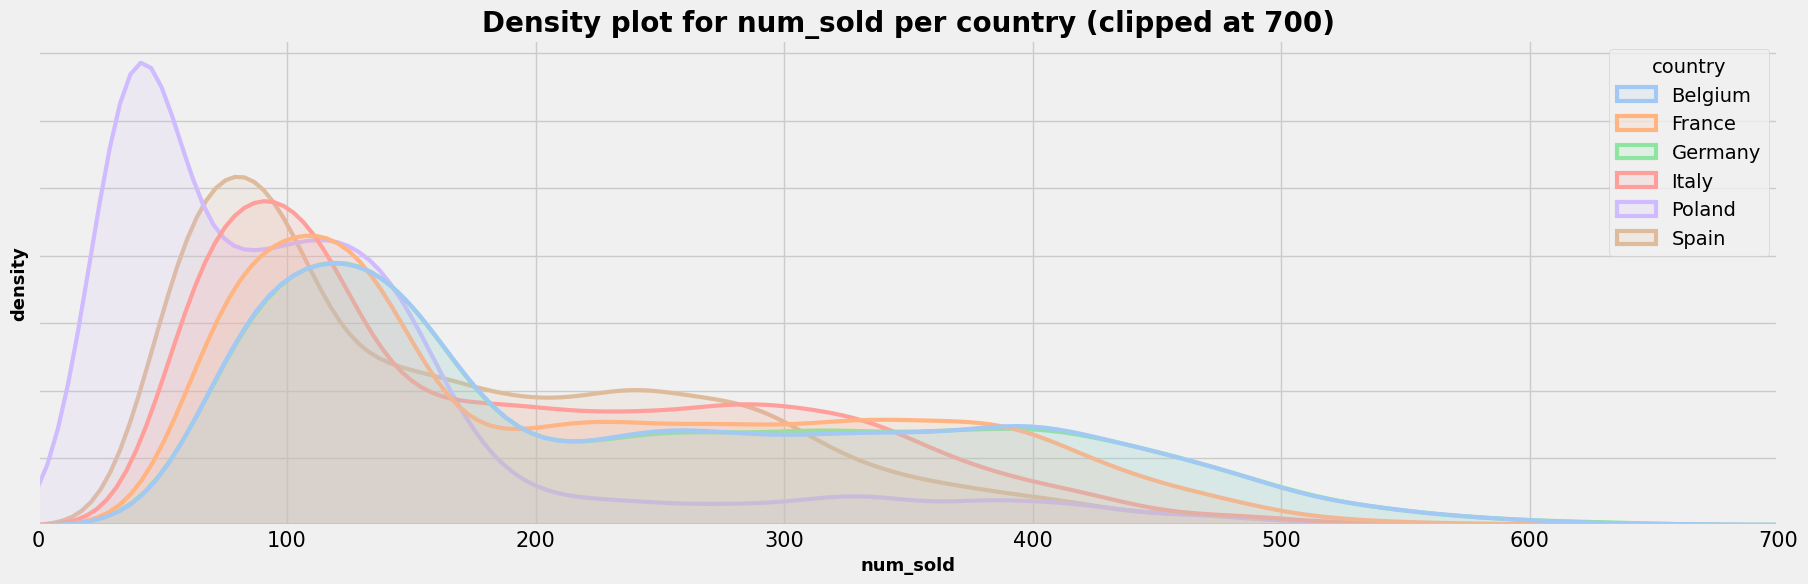

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=train, x = 'num_sold', hue = 'country', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for num_sold per country (clipped at 700)', fontweight = 'bold', fontsize = 20);

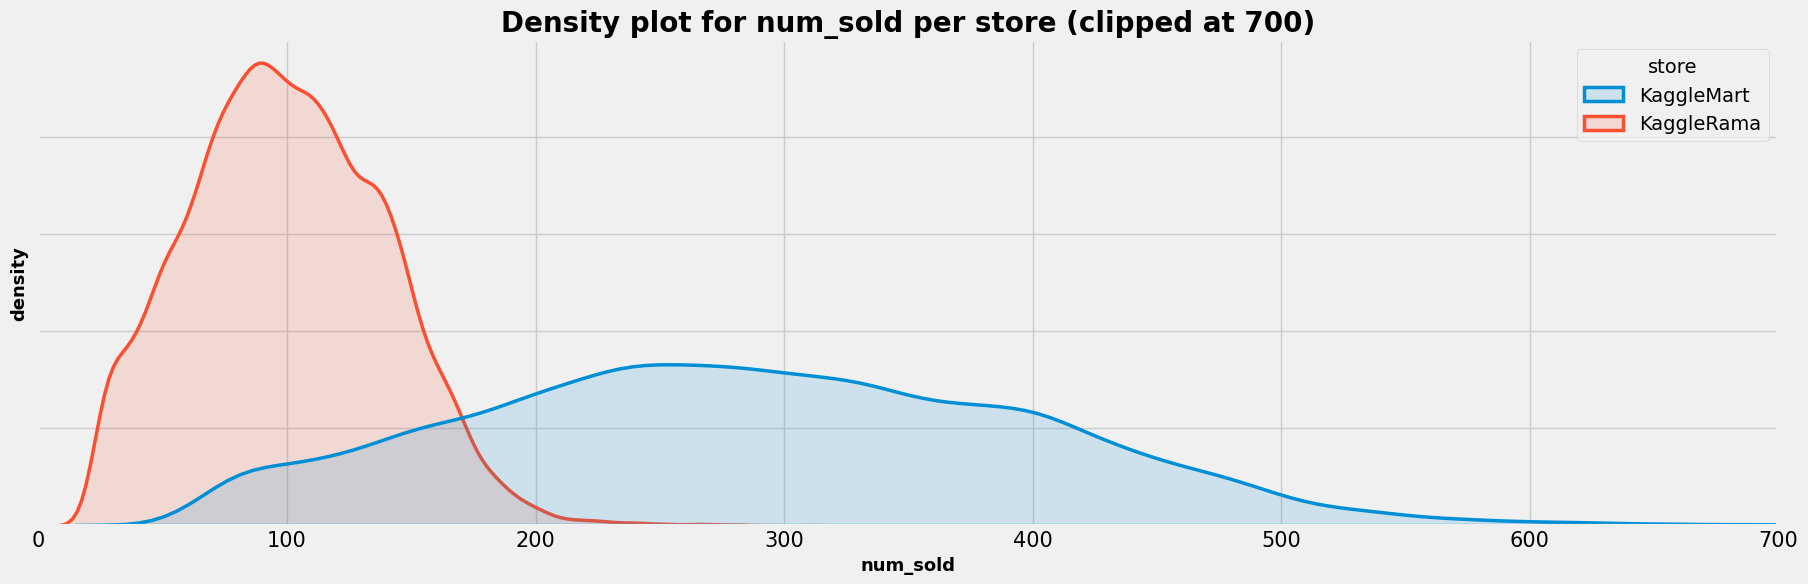

In [8]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=train, x = 'num_sold', hue = 'store', fill=True, alpha = 0.15, ax = ax, linewidth=2.5)
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.set_title('Density plot for num_sold per store (clipped at 700)', fontweight = 'bold', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([]);

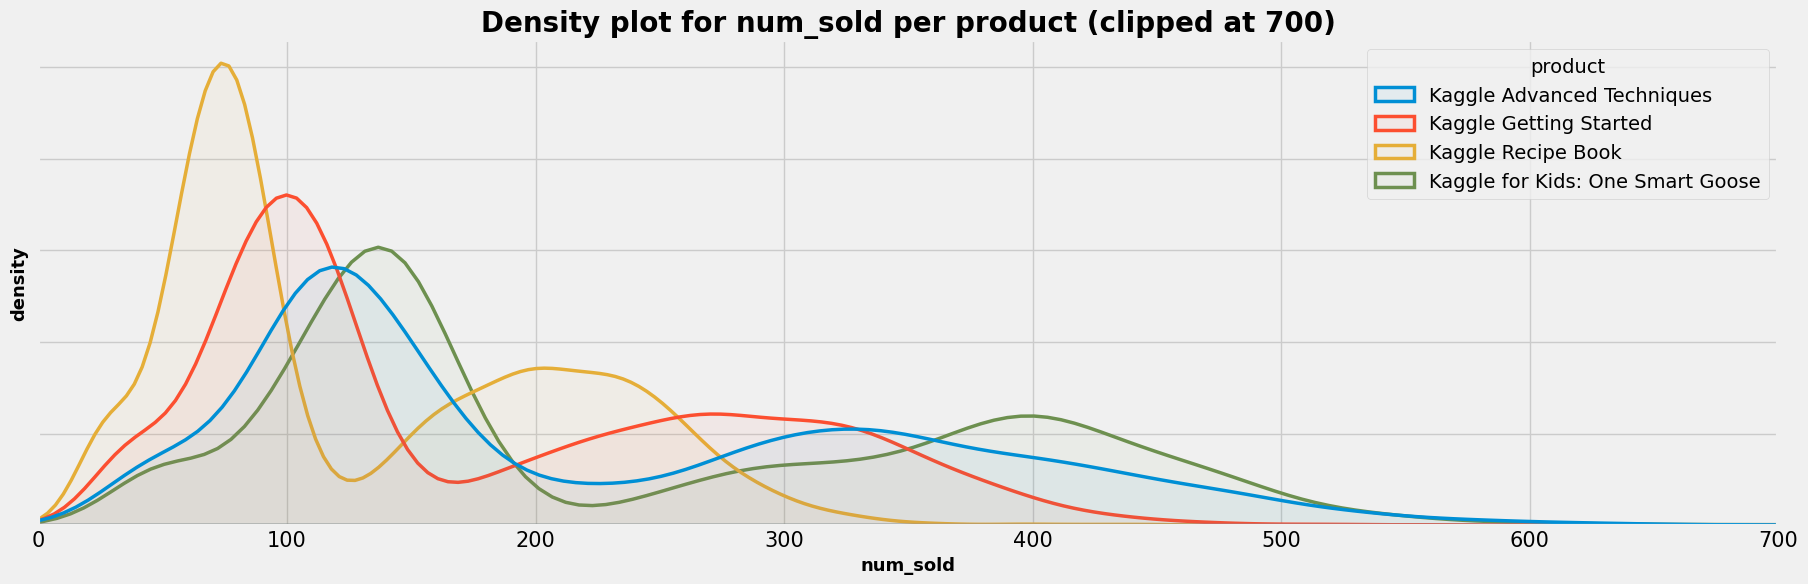

In [9]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=train, x = 'num_sold', hue = 'product', fill=True, alpha = 0.05, ax = ax, linewidth=2.5)
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.set_title('Density plot for num_sold per product (clipped at 700)', fontweight = 'bold', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([]);

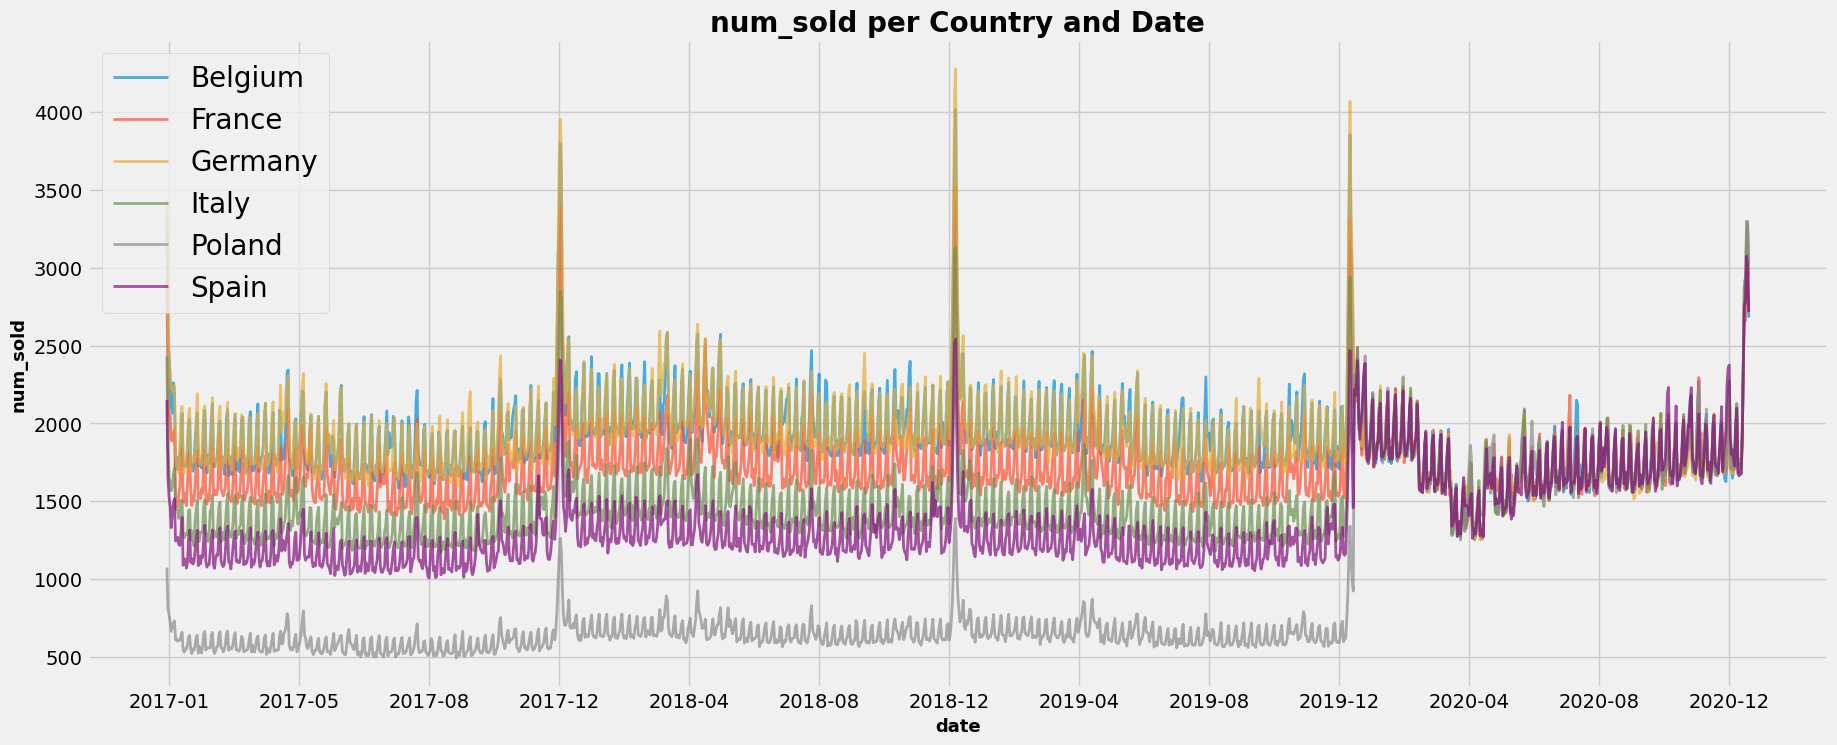

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='date',y='num_sold',hue='country',data=(train.groupby(['date', 'country']).num_sold.sum().rename('num_sold')
                                                       .reset_index().sort_values('date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) 
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.legend(fontsize = 20, loc = 'upper left')
ax.set_title('num_sold per Country and Date', fontweight = 'bold', fontsize = 20);

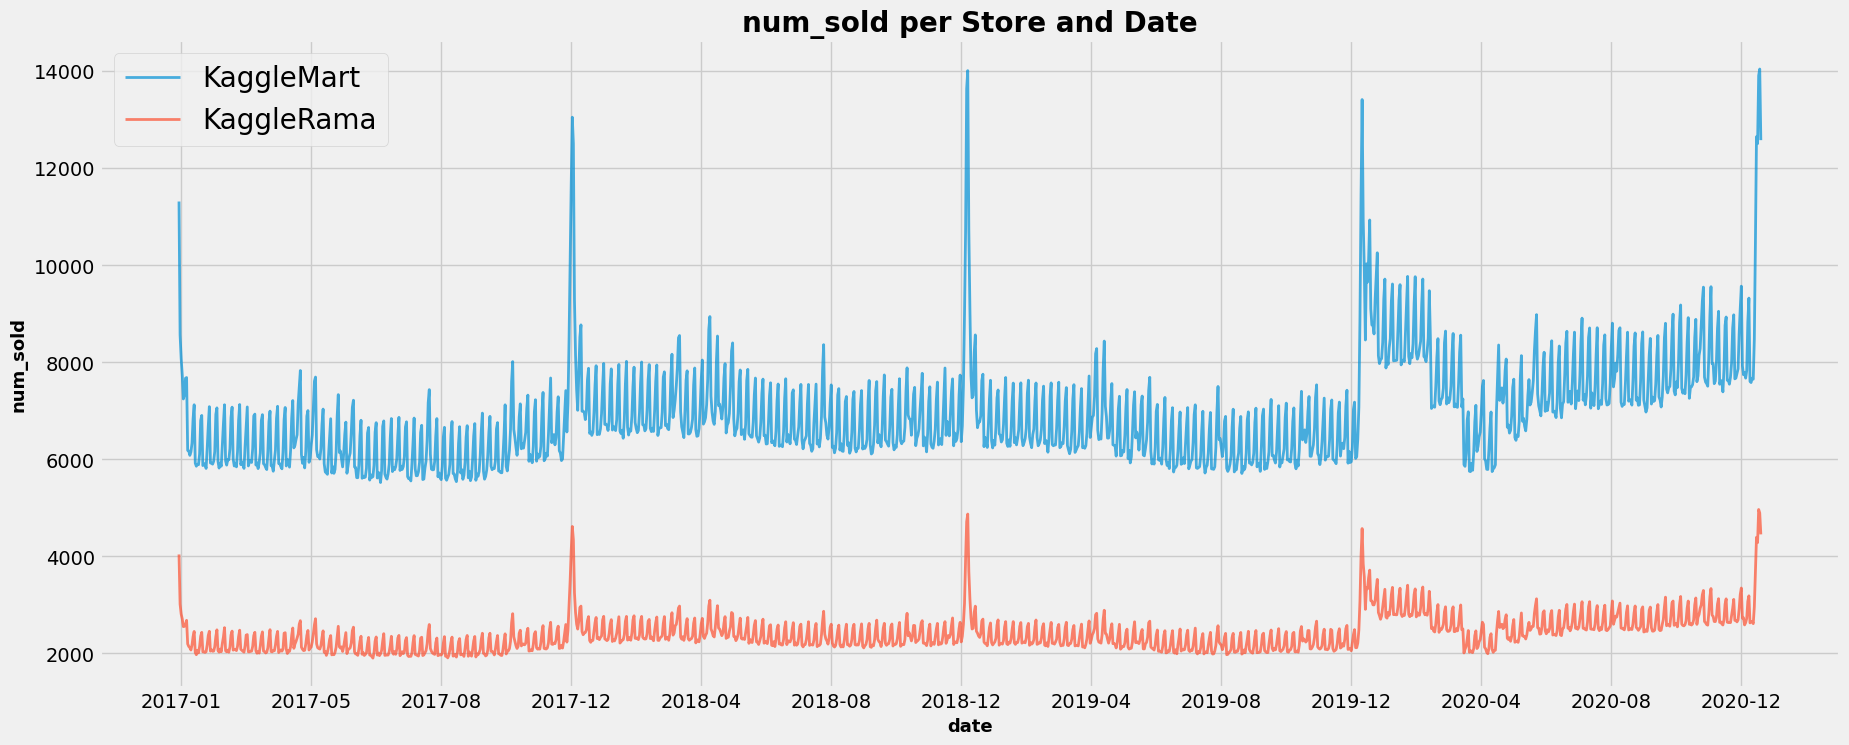

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='date',y='num_sold',hue='store',data=(train.groupby(['date', 'store']).num_sold.sum().rename('num_sold')
                                                       .reset_index().sort_values('date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) 
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_title('num_sold per Store and Date', fontweight = 'bold', fontsize = 20)
ax.legend(fontsize = 20, loc = 'upper left');

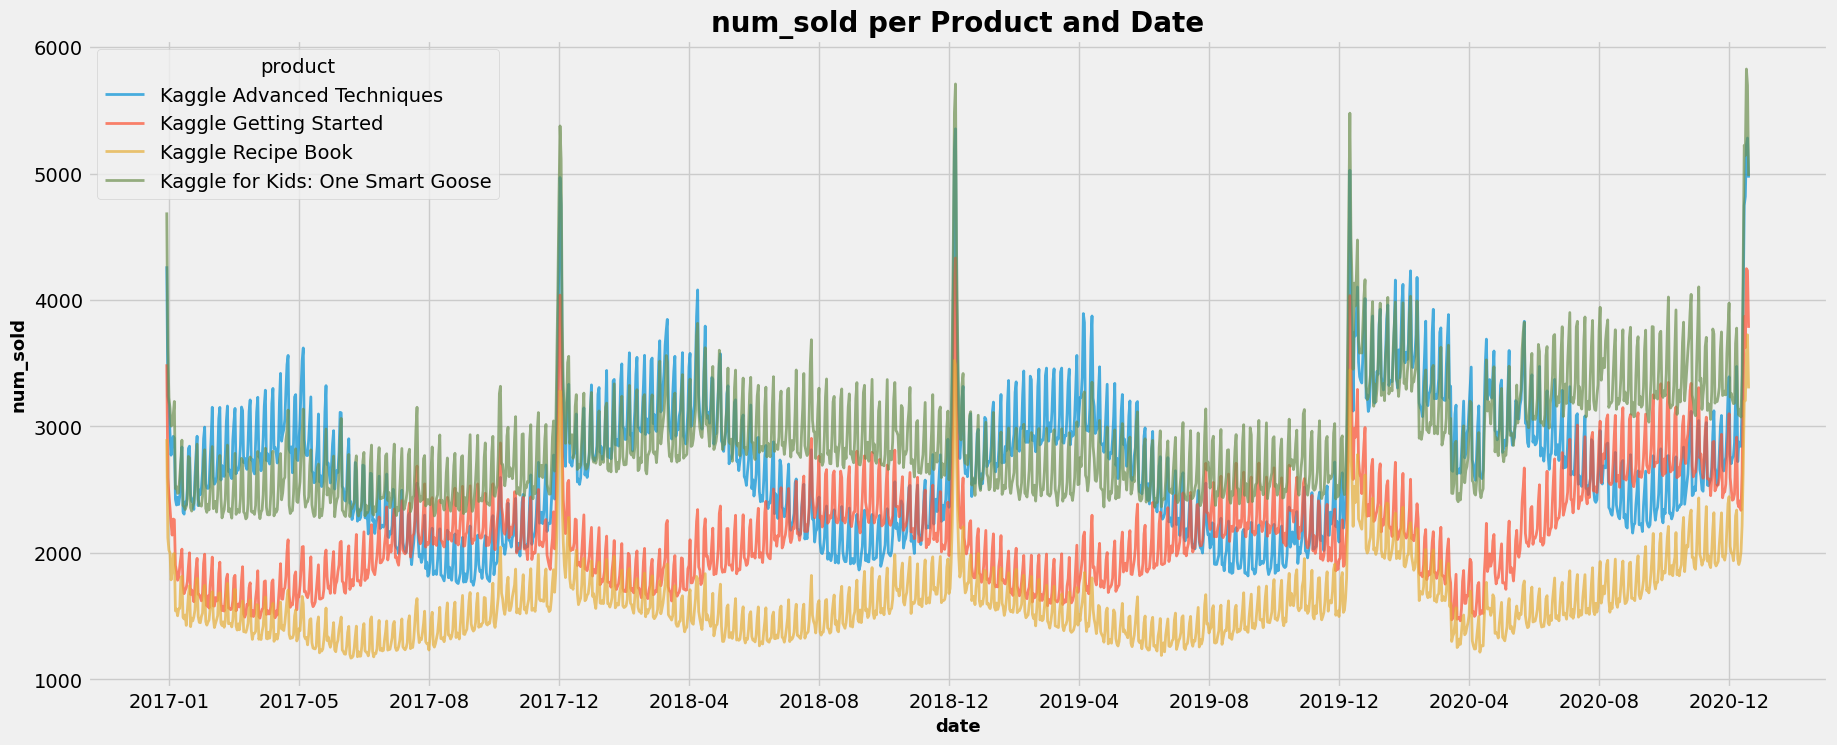

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='date',y='num_sold',hue='product',data=(train.groupby(['date', 'product']).num_sold.sum().rename('num_sold')
                                                       .reset_index().sort_values('date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) 
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_title('num_sold per Product and Date', fontweight = 'bold', fontsize = 20);

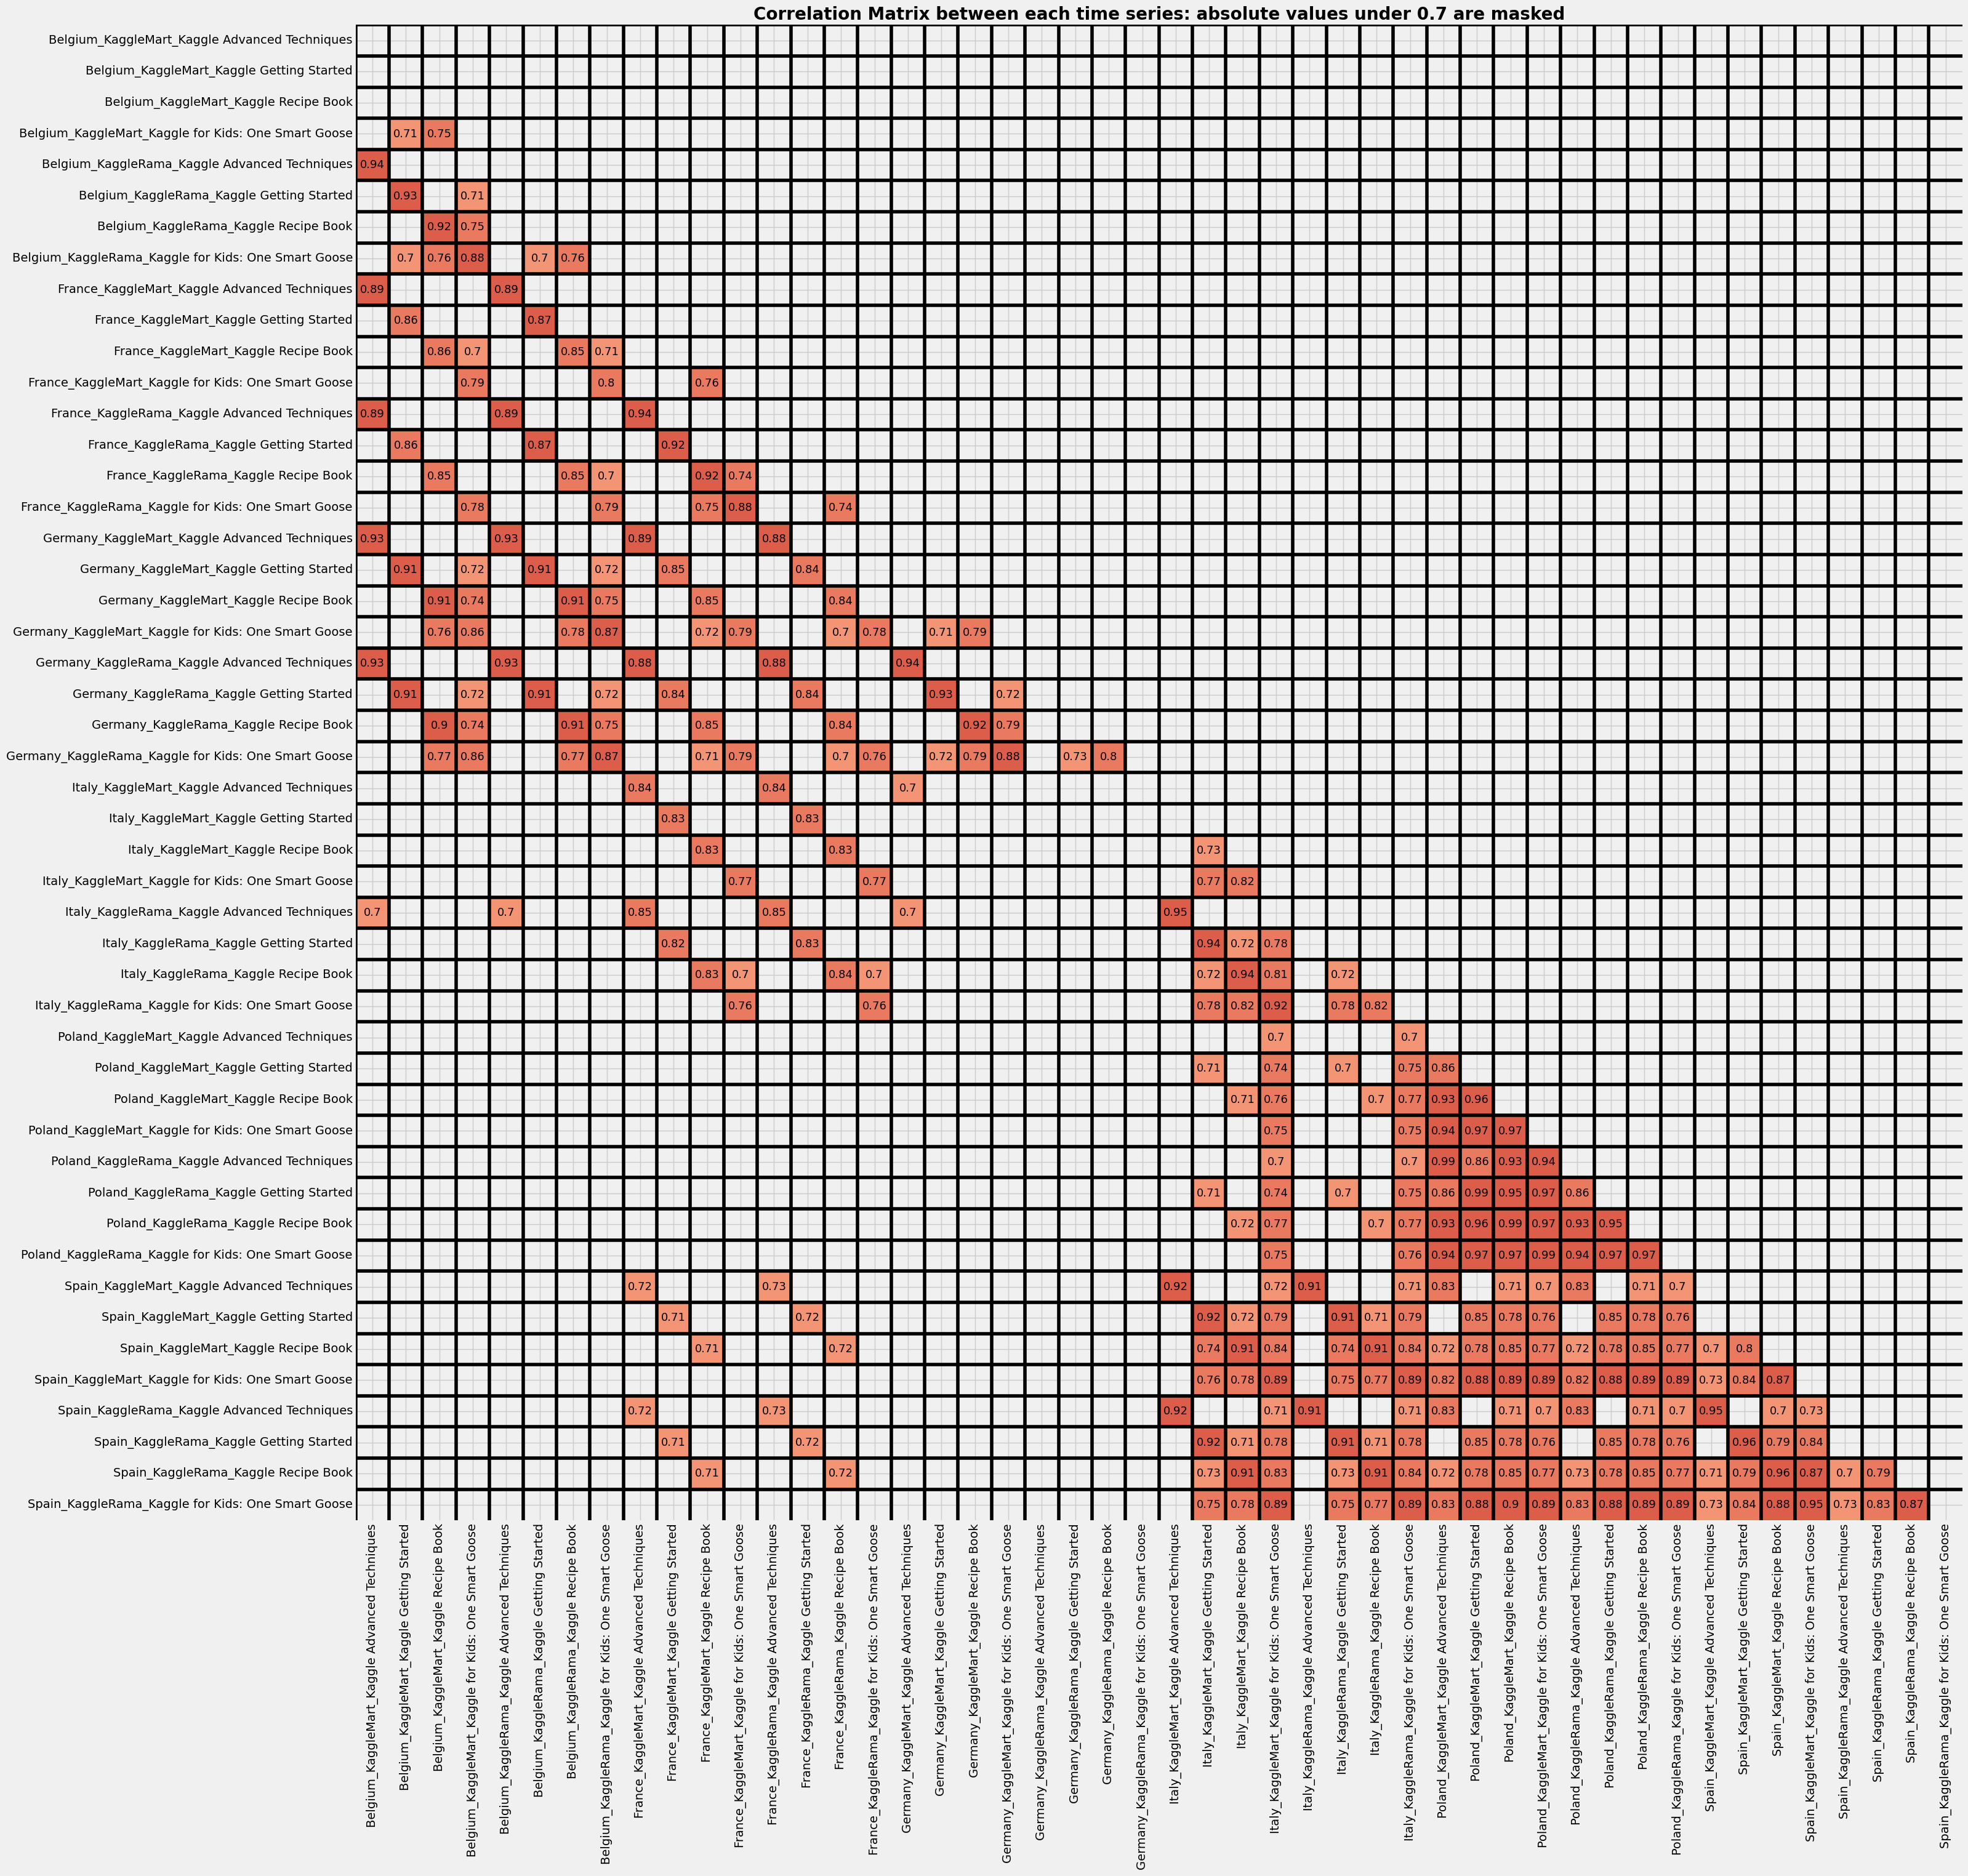

In [13]:
all_time_series = (train.drop(['row_id'], axis = 1).pivot(columns = ['country', 'store', 'product'], index = 'date', values = 'num_sold'))
all_time_series.columns = list(map(lambda x: "_".join(x), all_time_series.columns))

corr_matrix = round(all_time_series.corr(), 2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
colors = sns.color_palette('coolwarm', 16)
levels = np.linspace(-1, 1, 16)
cmap_plot, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend="max")

fig, ax = plt.subplots(1, 1, figsize = (30, 30))

mask_feature = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask = mask_feature | (np.abs(corr_matrix) < 0.7),
            annot=True, ax = ax, cbar=False,
            cmap = cmap_plot, 
            norm = norm, annot_kws={"size": 13, "color": 'black'
                                   # , 'fontweight' : 'bold'
                                   })

ax.hlines(range(corr_matrix.shape[1]), *ax.get_xlim(), color = 'black')
ax.vlines(range(corr_matrix.shape[1]), *ax.get_ylim(), color = 'black')

ax.set_title('Correlation Matrix between each time series: absolute values under 0.7 are masked', 
             fontsize = 20, color = 'black', fontweight = 'bold');

<a id ="2"></a><h4 style="background:#0554f2; border:0; border-radius: 4px; color:#f5f6f7">TFT Model </h4>

[Here](https://arxiv.org/abs/1912.09363) you can find the paper, developed by researchers at Google. From the Paper Abstract:

<i>Multi-horizon forecasting often contains a complex mix of inputs – including
static (i.e. time-invariant) covariates, known future inputs, and other exogenous
time series that are only observed in the past – without any prior information
on how they interact with the target. ...  In this paper, we introduce the Temporal Fusion Transformer (TFT) – a novel attentionbased architecture which combines high-performance multi-horizon forecasting
with interpretable insights into temporal dynamics. To learn temporal relationships at different scales, TFT uses recurrent layers for local processing and
interpretable self-attention layers for long-term dependencies. TFT utilizes specialized components to select relevant features and a series of gating layers to
suppress unnecessary components, enabling high performance in a wide range of
scenarios.</i>

Taken from the paper you can see the model architecture: 

<img src="https://i.imgur.com/mEx8Ocv.png" width="700"/>

---

<h5> Brief Overview </h5>

As the paper reports, the TFT Model can handle single or multiple targets and a whole lot of different covariates such as:

- *static covariates*: these are the ones that do not change through the course of the timeseries. In our case we have country, store and product, but we may have also real ones, such as the average number of people living in cities where a country-store pair resides;

- *time series covariates*, they actually belong to 2 different groups:
    - known in advance: such as day_of_the_week, month, holidays, etc.
    - unknown in advance: f.i. if we hade the stock level for each product, we would know it just in the past
    
    
The great thing is that `pytorch-forecasting` handles everything for us! 

<a id ="3"></a><h3 style="background:#0554f2; border:0; border-radius: 4px; color:#f5f6f7">Model Implementation in Pytorch-Forecasting </h3>

I had the idea of applying the TFT Model after going through [this](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html#Hyperparameter-tuning) in the torch-forecasting official documentation. The dataset used there is pretty much the same we are using here!

As you will see we basically don't need to do anything pytorch related (no need to implement a Dataset Class or anything, it's as easy as when you use a `sklearn` estimator). 

In [14]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)

data = (data.merge((data[['date']].drop_duplicates(ignore_index=True)
.rename_axis('time_idx')).reset_index(), on = ['date']))

In [16]:
# add additional features
data["day_of_week"] = data.date.dt.dayofweek.astype(str).astype("category")  # categories have be strings
#data["week_of_year"] = data.date.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_num_sold"] = np.log(data.num_sold + 1e-8)
data["avg_volume_by_country"] = data.groupby(["time_idx", "country"], observed=True).num_sold.transform("mean")
data["avg_volume_by_store"] = data.groupby(["time_idx", "store"], observed=True).num_sold.transform("mean")
data["avg_volume_by_product"] = data.groupby(["time_idx", "product"], observed=True).num_sold.transform("mean")

unique_dates_country = data[['date', 'country']].drop_duplicates(ignore_index = True)
unique_dates_country['is_holiday'] = (unique_dates_country
                                      .apply(lambda x: x.date in holidays.country_holidays(x.country), axis = 1).astype('category'))
unique_dates_country['is_holiday_lead_1'] = (unique_dates_country
                                             .apply(lambda x: x.date+pd.Timedelta(days=1) in holidays.country_holidays(x.country), axis = 1).astype('category'))
unique_dates_country['is_holiday_lead_2'] = (unique_dates_country
                                             .apply(lambda x: x.date+pd.Timedelta(days=2) in holidays.country_holidays(x.country), axis = 1).astype('category'))
unique_dates_country['is_holiday_lag_1'] = (unique_dates_country
                                            .apply(lambda x: x.date-pd.Timedelta(days=1) in holidays.country_holidays(x.country), axis = 1).astype('category'))
unique_dates_country['is_holiday_lag_2'] = (unique_dates_country
                                            .apply(lambda x: x.date-pd.Timedelta(days=2) in holidays.country_holidays(x.country), axis = 1).astype('category'))
data = data.merge(unique_dates_country, on = ['date', 'country'], validate = "m:1")
del unique_dates_country
gc.collect()
data.sample(5, random_state=30)


,row_id,date,country,store,product,num_sold,time_idx,day_of_week,month,log_num_sold,avg_volume_by_country,avg_volume_by_store,avg_volume_by_product,is_holiday,is_holiday_lead_1,is_holiday_lead_2,is_holiday_lag_1,is_holiday_lag_2
51207,51207,2019-12-03,Poland,KaggleRama,Kaggle for Kids: One Smart Goose,48.0,1066,1,12,3.871201,74.625,85.125000,202.500000,False,False,False,False,False
7116,7116,2017-05-29,France,KaggleRama,Kaggle Advanced Techniques,146.0,148,0,5,4.983607,209.250,88.958333,224.916667,False,False,False,False,False
47561,47561,2019-09-18,Spain,KaggleMart,Kaggle Getting Started,219.0,990,2,9,5.389072,135.250,245.166667,187.916667,False,False,False,False,False
39225,39225,2019-03-29,France,KaggleMart,Kaggle Getting Started,253.0,817,4,3,5.533389,215.625,277.708333,140.583333,False,False,False,False,False
19956,19956,2018-02-20,Poland,KaggleRama,Kaggle Advanced Techniques,51.0,415,1,2,3.931826,79.250,95.291667,237.750000,False,False,False,False,False


In [17]:
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

max_prediction_length = 365 # We will predict the entire 2021 year 
max_encoder_length = train.date.nunique()
training_cutoff = train["time_idx"].max() - max_prediction_length #we will validate on 2020

In [19]:
# Let's create a Dataset
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff].drop('row_id', axis = 1),
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"], 
    min_encoder_length=max_prediction_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["country", "store", "product"],
    time_varying_known_categoricals=["month", "day_of_week", "is_holiday",
                                     "is_holiday_lead_1", "is_holiday_lead_2",
                                     "is_holiday_lag_1", "is_holiday_lag_2"],
    #variable_groups={"is_holiday": ["is_holiday"]},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "num_sold", "log_num_sold", "avg_volume_by_country",
        "avg_volume_by_store", "avg_volume_by_product"
    ],
    target_normalizer=GroupNormalizer(
        groups=["country", "store", "product"], transformation="softplus"
    ),  # use softplus and normalize by group
    categorical_encoders={
        'day_of_week':NaNLabelEncoder(add_nan=True)
    },
    lags={'num_sold': [7, 30, 365]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

ValueError: Data type of category is_holiday was found to be numeric - use a string type / categorified string

In [ ]:
#let's see how a naive model does

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

sm = SMAPE()

In [ ]:
print(f"Median loss for naive prediction on validation: {sm.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

<a id ="4"></a><h3 style="background:#0554f2; border:0; border-radius: 4px; color:#f5f6f7">Training and Evaluation</h3>

I'm not particularly interested in performances, rather in showing how easy it is to use the library.

In [20]:
PATIENCE = 30
MAX_EPOCHS = 120
LEARNING_RATE = 0.03
OPTUNA = False

In [21]:
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard



trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=1,
    devices=1, accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.25,
    limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=SMAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)

tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

TypeError: __init__() got an unexpected keyword argument 'gpus'

In [22]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

NameError: name 'trainer' is not defined

In [23]:
if OPTUNA:

    from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

    # create study
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=50,
        max_epochs=50,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=30),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    )

In [24]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, mode="prediction")
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sm = SMAPE()
print(f"Validation median SMAPE loss: {sm.loss(actuals, predictions).mean(axis = 1).median().item()}")

NameError: name 'trainer' is not defined

In [25]:
for idx in range(raw_predictions.prediction.shape[0]):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

NameError: name 'raw_predictions' is not defined

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
all_features = list(set(predictions_vs_actuals['support'].keys())-set(['num_sold_lagged_by_365', 'num_sold_lagged_by_30', 'num_sold_lagged_by_7']))
for feature in all_features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature);

<a id ="5"></a><h3 style="background:#0554f2; border:0; border-radius: 4px; color:#f5f6f7">Submission</h3>

WIP